In [2]:
import os
import schnetpack as spk
import schnetpack.transform as trn
import matplotlib.pyplot as plt
import torch
from ase.build import molecule
from ase import Atoms
from schnetpack.interfaces import AtomsConverter
import numpy as np
from tqdm import tqdm
from agox.utils.plot import plot_atoms, plot_cell

(Disclaimer: This notebook is not very polished, it is basically just some experiments with equivariant networks.)

# Equivariant Representations.

`SchNetPack` provides tools for creating models using invariant and equivariant representations. I will not 
attempt explaining how that is done see the [PaiNN paper](https://arxiv.org/pdf/2102.03150.pdf). 
The focus of this notebook is to show that these tools can be used to create networks 
that have useful properties for 'atomistic RL'. 

We can try to use these build RL algorithms rather than just property predictors, 
but first we need to be a little familiar with `SchNetPack`

Below I set up a `SchNet` and a `PaiNN`-representation. The representations produce
- SchNet
    - An invariant scalar representation.
- PaiNN
    - An invariant scalar representation. 
    - An equivariant vector representation. 

As the below code will show, it is the equivariant vector representation that we are most interested in. 

In [3]:
cutoff = 5.
n_atom_basis = 30

pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
representation_painn = spk.representation.PaiNN(
    n_atom_basis=n_atom_basis, n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

representation_schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis, n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

To create the tensors needed to call these representation classes we use some 
functions that can take ASE atoms objects as input and produce the appropriate input data 
for the represeentations. 

In [4]:
converter = AtomsConverter(
    neighbor_list=trn.ASENeighborList(cutoff=5),    
    dtype=torch.float32)

pairwise_distance = spk.atomistic.PairwiseDistances()

Below I create a system consisting of one carbon atom and one hydrogen atom, with the hydrogen 
atom being moved around in a circle around the carbon. 
For every configuration I calculate the schnet and painn representations. The 
`SchNetPack` code returns these as dicts. 

In [5]:
thetas = np.linspace(0, 2*np.pi, 100)

r = 1

trajectory = []
equi_representations = []
inv_representations = []
for theta in thetas:
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    atoms = Atoms('CH', positions=np.array([[0, 0, 0], [0, x, y]]))

    equi_rep = representation_painn(pairwise_distance(converter(atoms)))
    inv_rep = representation_schnet(pairwise_distance(converter(atoms)))

    trajectory.append(atoms)
    equi_representations.append(equi_rep)
    inv_representations.append(inv_rep)

The invariant representations produced by `SchNet` are equal for all of these configurations. 

In [6]:
r1 = inv_representations[0]['scalar_representation']
r2 = inv_representations[25]['scalar_representation']
print(torch.allclose(r1, r2, 1e-5))

True


The same is true for the `scalar_representations` of the equivariant representations. 
(Though they do seem to have some noise on ~1e-6, if you want to convince yourself that it is just noise, plot some of the components as a function of the angle.)

In [11]:
r1 = equi_representations[0]['scalar_representation']
r2 = equi_representations[25]['scalar_representation']
print(torch.allclose(r1, r2, 1e-4)) # There are some numerical error.

True


The `PaiNN` representation also produces a vector representation which is the equivariant one! 

In [8]:
r1 = equi_representations[0]['vector_representation']
r2 = equi_representations[10]['vector_representation']
print(torch.allclose(r1, r2, 1e-1))

False


Just to illustrate the point further, we can setup a simple little experiment using our data from above. 
The question being: Can we from each of the representations predict the angle $\theta$? 

Start by setting up a a little fully connected network, my choices here are pretty arbitrary. 

In [31]:
class AnglePrediction(torch.nn.Module):

    def __init__(self, input_size):
        super(AnglePrediction, self).__init__()

        input_size = input_size
        self.layer1 = torch.nn.Linear(input_size, 64)
        self.layer2 = torch.nn.Linear(64, 32)
        self.layer3 = torch.nn.Linear(32, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def train(self, data, target):
        output = self.forward(data)
        loss = torch.nn.functional.mse_loss(output, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

Gather all the representations

In [12]:
# Our training target is the angles:
target = torch.tensor(thetas, dtype=torch.float32).reshape(-1, 1)

# We have three possible representations:
inv_scalar = [r['scalar_representation'].detach() for r in inv_representations]
equi_scalar = [r['scalar_representation'].detach() for r in equi_representations]
equi_vector = [r['vector_representation'].detach() for r in equi_representations]
representations = [inv_scalar, equi_scalar, equi_vector]

Train a model with each representation

In [13]:
trained_models = []
for rep in representations:

    X_flat = torch.stack(rep).view(len(rep), -1) # Flatten for the fully connected network

    network = AnglePrediction(X_flat.shape[1])
    steps = 500
    loss = np.zeros(steps)
    for step in tqdm(range(steps)):
        loss[step] = network.train(X_flat, target)

    trained_models.append(network)

100%|██████████| 500/500 [00:15<00:00, 33.19it/s]


And finally we can plot the predicted angles as a function of the true angles. 

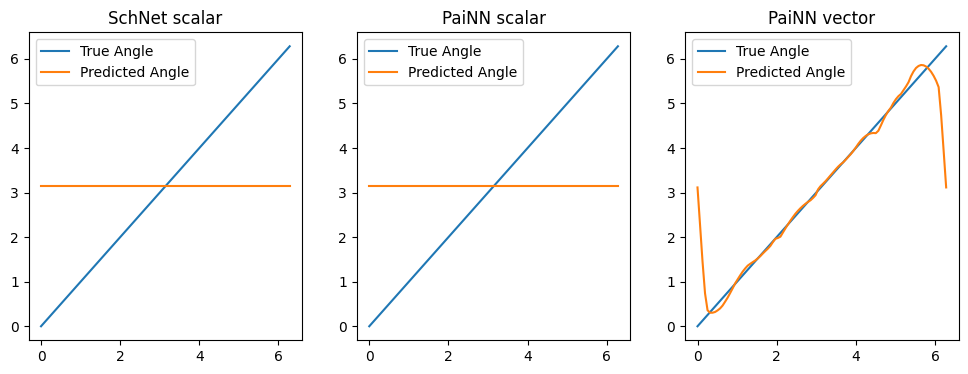

In [23]:
sz = 4
fig, ax = plt.subplots(1, 3, figsize=(3*sz, 1*sz))

labels = ['SchNet scalar', 'PaiNN scalar', 'PaiNN vector']

for i, (network, rep, label) in enumerate(zip(trained_models, representations, labels)):

    X_flat = torch.stack(rep).view(len(rep), -1)
    pred_thetas = network(X_flat)    

    ax[i].plot(thetas, thetas, label='True Angle')
    ax[i].plot(thetas, pred_thetas.detach().numpy(), label='Predicted Angle')
    ax[i].legend()
    ax[i].set_title(label)

It is clearly only the equivariant vector representation that is capable of learning this property. It is difficult to learn a changing target value with a constant as input...

Interestingly this example also show cases another common concern namely uniqueness - the representations for 
$\theta \approx 0$ are the same as they are for $\theta \approx 2 \pi$, so the network cannot really learn this region. 

I have effectively used a global descriptor by stacking the atomic descriptors to make these predictions, you can confirm that it also works with just a local feature of one the atoms if you want to. 

### Using PaiNN as a layer. 

In [46]:
class AgentTemplate(torch.nn.Module): 

    def __init__(self, cutoff=5, n_atom_basis=10):
        super().__init__()

        self.pairwise_distance = spk.atomistic.PairwiseDistances()
        
        radial_basis = spk.nn.GaussianRBF(n_rbf=30, cutoff=cutoff)
        self.representation = spk.representation.PaiNN(
            n_atom_basis=n_atom_basis, n_interactions=3,
            radial_basis=radial_basis,
            cutoff_fn=spk.nn.CosineCutoff(cutoff)

        )
        
        self.converter = AtomsConverter(
            neighbor_list=trn.ASENeighborList(cutoff=cutoff),    
            dtype=torch.float32)

        # Some sizes that are useful to keep in mind: 
        atomic_scalar_size = n_atom_basis
        atomic_vector_size = 3 * n_atom_basis        

        # Atomic invariant model:
        self.atomic_invariant_model = torch.nn.Sequential(
                torch.nn.Linear(atomic_scalar_size, 10),
                torch.nn.ReLU(),
                torch.nn.Linear(10, 1)
                    )
        # Atomic (semi)-equivariant model:
        self.atomic_equi_model = torch.nn.Sequential(
                torch.nn.Linear(atomic_vector_size, 10),
                torch.nn.Linear(10, 3) 
                    )

        # Atom-wise sum model just like is used for energy predictions.
        # A to the ones above little different as this expects a dict of tensors as input. 
        self.atom_sum_model = spk.atomistic.Atomwise(n_in=atomic_scalar_size, output_key='some_scalar')
        # Alternatively you can sum over the atomic properties produced by either of the above models.
    
    def convert(self, atoms):
        """
        Returns a dictionary of tensors that can be used as input to the model.

        Important keys: 
        scalar representations:
            Has size (n_atoms, n_atom_basis)
        vector_representations:
            Has size (n_atoms, 3, n_atom_basis)
        """
        return self.pairwise_distance(self.converter(atoms))

    def forward(self, tensors):
        rep = self.representation(tensors)

        vector_rep = rep['vector_representation']
        vector_rep = vector_rep.view(-1, 3 * self.representation.n_atom_basis)
        scalar_rep = rep['scalar_representation']

        # As is these will see the atom-dimension of these as a batch dimension. 
        # and will return predictions for all atoms at once.        
        scalar_output = self.atomic_invariant_model(scalar_rep)
        vector_output = self.atomic_equi_model(vector_rep)

        return scalar_output, vector_output



In [3]:
atoms = molecule('H2O')
agent = AgentTemplate()

tensors = agent.representation(agent.convert(atoms))

invariant_rep = tensors['scalar_representation']
vector_rep = tensors['vector_representation']

In [4]:
scalar, vector = agent.forward(tensors)

# The scalar outputs could perhaps be actions preferences (that could be turned into probabilities with a softmax).
print(scalar)

# The vector outputs could be displacements associated with each atom. 
print(vector)

tensor([[-0.4195],
        [ 0.2260],
        [ 0.2260]], grad_fn=<AddmmBackward0>)
tensor([[-0.1906,  0.2087, -0.0895],
        [-0.1710,  0.2376, -0.0610],
        [-0.0966,  0.1552, -0.0053]], grad_fn=<AddmmBackward0>)


### Weird test system: 

In [7]:
dx = 1.5
chain = Atoms('CCOCC', positions=[[0,0,0],[dx,0,0],[2*dx,0,0],[3*dx,0,0],[4*dx,0,0]])
target_position = [2*dx, 1, 0]

def random_config():
    config = chain.copy()
    # Add a hydrogen: 
    x = np.random.rand()*5
    y = np.random.rand()*2 + 1 
    config += Atoms('H', positions=[[x , y, 0]])
    return config

network = AgentTemplate()

n_data = 100
training_data = [random_config() for _ in range(n_data)]

target_disploacements = torch.tensor(np.array([config.positions[-1]-target_position for config in training_data]))

optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

all_tensors = network.convert(training_data)

n_steps = 350
losses = np.zeros(n_steps)

# Kind of inefficient because I'm not using batches. 
for step in tqdm(range(n_steps)):

    scalars, vectors = network(all_tensors)

    vectors = vectors.view(n_data, -1, 3) # Only works if there are an equal number of atoms in each config

    # Want just the last vector from each config
    vectors = vectors[:, -1, :]

    loss = torch.mean(torch.norm(target_disploacements - vectors, dim=1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[step] = loss.item()

100%|██████████| 350/350 [03:27<00:00,  1.68it/s]


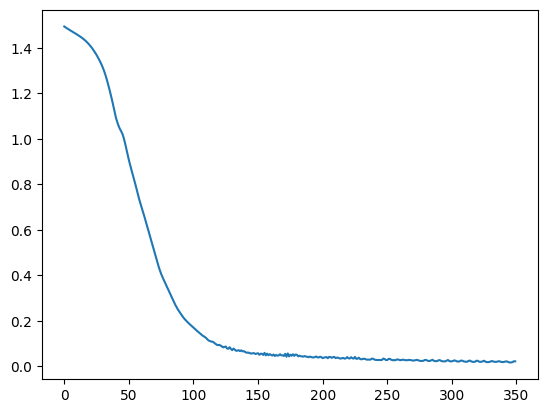

In [8]:
plt.plot(losses)

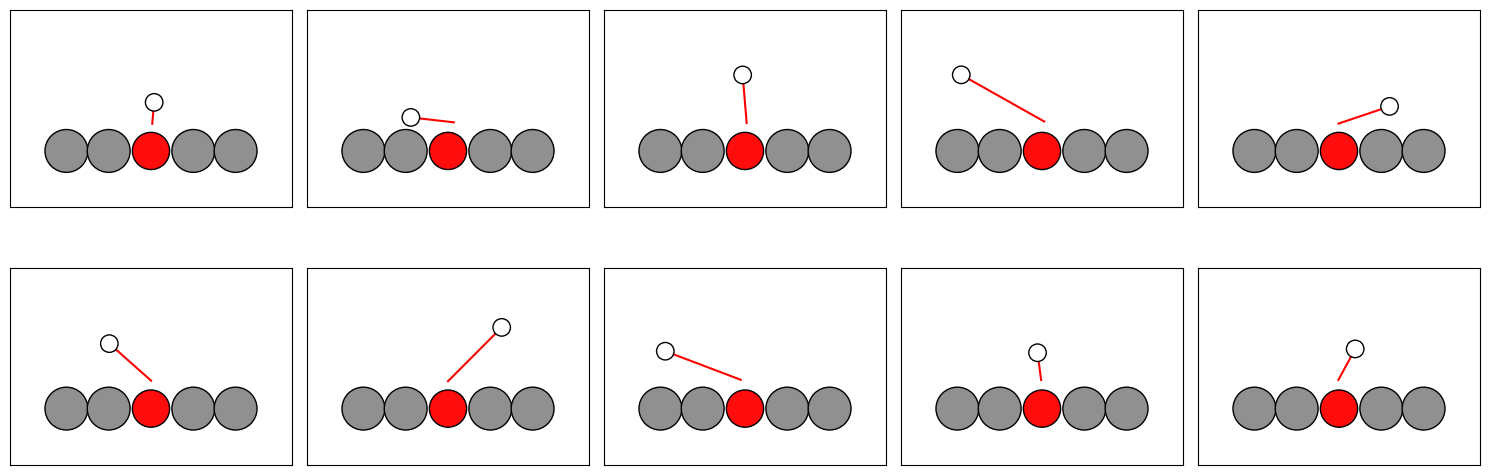

In [10]:
# Try the trained model on some system: 

sz = 3
fig, axes = plt.subplots(2, 5, figsize=(5*sz, 2*sz))

for ax in axes.flatten():

    test_config = random_config()
    tensor = network.convert(test_config)

    s, v = network(tensor)
    plot_atoms(ax, test_config)

    p1 = test_config.positions[-1, :]
    p2 = p1 - v[-1, :].detach().numpy()

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], "r-", zorder=0)

    ax.set_xlim([-2, 8])
    ax.set_ylim([-2, 5])

plt.tight_layout()

So the model is definetly capable of learning a vector output when taught in this sort of very direct manner. 

Below I change it to having all atoms moved at least out of the original positions. 

In [47]:
dx = 1.5
chain = Atoms('CCOCC', positions=[[0,0,0],[dx,0,0],[2*dx,0,0],[3*dx,0,0],[4*dx,0,0]])

p0 = chain.positions.copy()
p0 = np.append(p0, [[2*dx,1,0]], axis=0)

target_position = [2*dx, 1, 0]

def random_config():
    config = chain.copy()
    config.rattle(0.25)
    # Add a hydrogen: 
    x = np.random.rand()*5
    y = np.random.rand()*2 + 1 
    config += Atoms('H', positions=[[x , y, 0]])
    return config

network = AgentTemplate()

n_data = 100
training_data = [random_config() for _ in range(n_data)]

target_disploacements = torch.tensor(np.array([p0-config.positions for config in training_data]))

optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

all_tensors = network.convert(training_data)

n_steps = 400
losses = np.zeros(n_steps)

# Kind of inefficient because I'm not using batches. 
for step in tqdm(range(n_steps)):

    scalars, vectors = network(all_tensors)

    vectors = vectors.view(n_data, -1, 3) # Only works if there are an equal number of atoms in each config
    loss = torch.mean(torch.norm(vectors - target_disploacements, dim=1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[step] = loss.item()

100%|██████████| 400/400 [04:53<00:00,  1.36it/s]


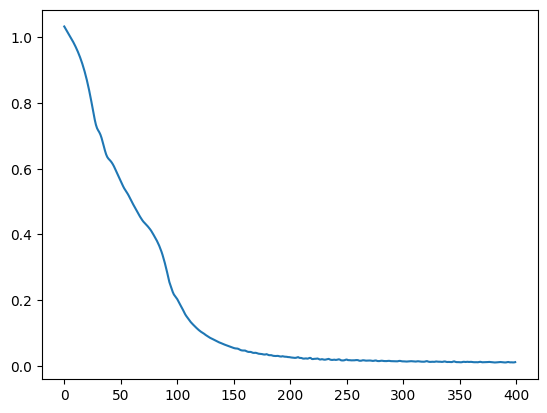

In [48]:
plt.plot(losses)

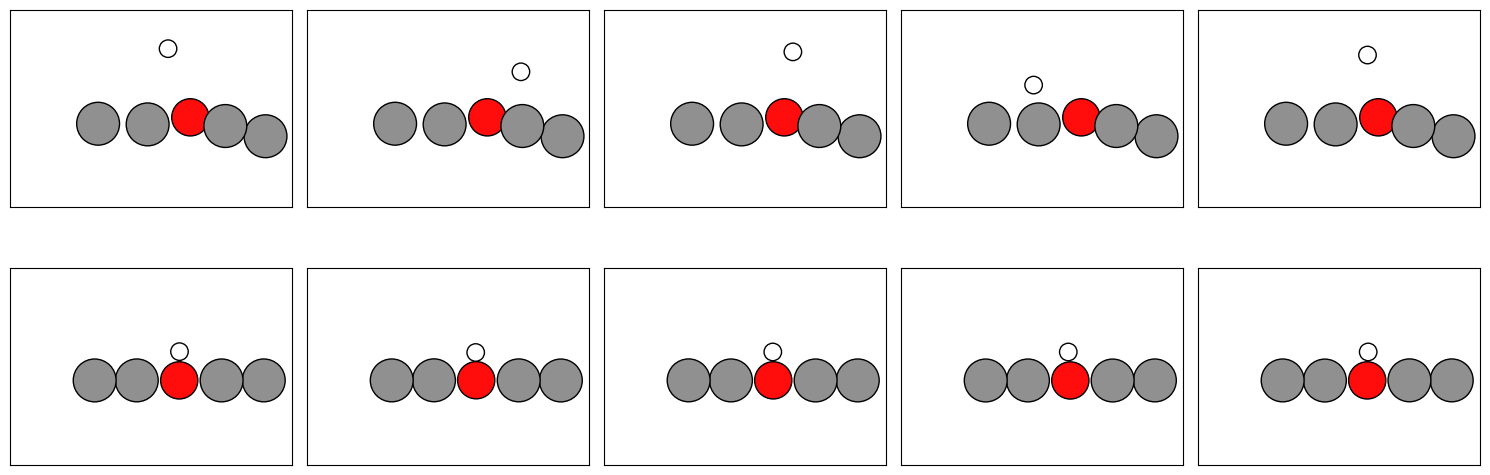

In [54]:
# Try the trained model on some system: 

sz = 3
ncols = 5
fig, axes = plt.subplots(2, ncols, figsize=(ncols*sz, 2*sz))

for c in range(ncols):

    test_config = random_config()
    test_config.positions += 1 # Translation
    positions_copy = test_config.positions.copy()
    test_config.positions[3, :] = positions_copy[4, :] # Permutation
    test_config.positions[4, :] = positions_copy[3, :] # Permutaiton. 

    # Doesnt work too well.. Because the final layer is not equivariant.
    test_config.rotate(0, [0, 0, 1], center=test_config.positions.mean(axis=0)) # Rotation

    tensor = network.convert(test_config)
    s, v = network(tensor)

    ax = axes[0, c]
    plot_atoms(ax, test_config)

    # for i in range(len(test_config)):
    #     p1 = test_config.positions[i, :]
    #     p2 = p1 + v[i, :].detach().numpy() # Must have a sign wrong somewhere since this is negative. 

    #     ax.plot([p1[0], p2[0]], [p1[1], p2[1]], "g-", zorder=5)

    ax.set_xlim([-2, 8])
    ax.set_ylim([-2, 5])

    ax = axes[1, c]

    test_config.positions += v.detach().numpy()
    plot_atoms(ax, test_config)

    ax.set_xlim([-2, 8])
    ax.set_ylim([-2, 5])

plt.tight_layout()

As can be seen form the above examples when turning on random rotations, 
the equivariance has been broken. 

To fix this one would need to use an equivariant final prediction layer, 
one such is implemented in schnetpack as `schnetpack.nn.equivariant.GatedEquivariantBlock`.

Here the top row are initial structures and the bottom row are final structures after applying the displacment predicted by the network. 

<div class="alert alert-block alert-success">
Even outside of RL this is really rather interesting, it could for example be used to train a network 
that predicts the outcome of relaxations - with the ultimate goal of being able to 
entirely skip doing an actual relaxation with just 'one-shot' calculation! 
This can (and probably should..) be tested with a dataset of relaxation trajectories. 
The trajectory consists of configurations $[c_0, c_1, .., c_T]$ and for every step the network can be trained to predict the 
displacements that bring $c_t$ to be $c_T$. 
</div>

In [41]:
class AgentTemplate(torch.nn.Module): 

    def __init__(self, cutoff=5, n_atom_basis=10):
        super().__init__()

        self.pairwise_distance = spk.atomistic.PairwiseDistances()
        
        radial_basis = spk.nn.GaussianRBF(n_rbf=30, cutoff=cutoff)
        self.representation = spk.representation.PaiNN(
            n_atom_basis=n_atom_basis, n_interactions=3,
            radial_basis=radial_basis,
            cutoff_fn=spk.nn.CosineCutoff(cutoff)

        )
        
        self.converter = AtomsConverter(
            neighbor_list=trn.ASENeighborList(cutoff=cutoff),    
            dtype=torch.float32)

        # Some sizes that are useful to keep in mind: 
        atomic_scalar_size = n_atom_basis
        atomic_vector_size = 3 * n_atom_basis        

        # Atomic invariant model:
        self.atomic_invariant_model = torch.nn.Sequential(
                torch.nn.Linear(atomic_scalar_size, 10),
                torch.nn.ReLU(),
                torch.nn.Linear(10, 1)
                    )
        # Atomic (semi)-equivariant model:
        self.atomic_equi_model = spk.nn.blocks.build_gated_equivariant_mlp(n_atom_basis, 1)

        # Atom-wise sum model just like is used for energy predictions.
        # A to the ones above little different as this expects a dict of tensors as input. 
        self.atom_sum_model = spk.atomistic.Atomwise(n_in=atomic_scalar_size, output_key='some_scalar')
        # Alternatively you can sum over the atomic properties produced by either of the above models.
    
    def convert(self, atoms):
        """
        Returns a dictionary of tensors that can be used as input to the model.

        Important keys: 
        scalar representations:
            Has size (n_atoms, n_atom_basis)
        vector_representations:
            Has size (n_atoms, 3, n_atom_basis)
        """
        return self.pairwise_distance(self.converter(atoms))

    def forward(self, tensors):
        rep = self.representation(tensors)

        vector_rep = rep['vector_representation']
        # vector_rep = vector_rep.view(-1, 3 * self.representation.n_atom_basis)
        scalar_rep = rep['scalar_representation']

        # # As is these will see the atom-dimension of these as a batch dimension. 
        # # and will return predictions for all atoms at once.        
        # #scalar_output = self.atomic_invariant_model(scalar_rep)
        # #vector_output = self.atomic_equi_model(vector_rep)

        scalar, vector = self.atomic_equi_model([scalar_rep, vector_rep])

        #return scalar, vector
        return scalar, vector


In [67]:
dx = 1.5
chain = Atoms('CCOCC', positions=[[0,0,0],[dx,0,0],[2*dx,0,0],[3*dx,0,0],[4*dx,0,0]])

p0 = chain.positions.copy()
p0 = np.append(p0, [[2*dx,1,0]], axis=0)

target_position = [2*dx, 1, 0]

def random_config():
    config = chain.copy()
    config.rattle(0.25)
    # Add a hydrogen: 
    x = np.random.rand()*5
    y = np.random.rand()*2 + 1 
    config += Atoms('H', positions=[[x , y, 0]])
    return config

network = AgentTemplate()

n_data = 100
training_data = [random_config() for _ in range(n_data)]

target_disploacements = torch.tensor(np.array([p0-config.positions for config in training_data]))

optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

all_tensors = network.convert(training_data)

n_steps = 400
losses = np.zeros(n_steps)

# Kind of inefficient because I'm not using batches. 
for step in tqdm(range(n_steps)):

    scalars, vectors = network(all_tensors)

    vectors = vectors.view(n_data, -1, 3)

    vectors = vectors.view(n_data, -1, 3) # Only works if there are an equal number of atoms in each config
    
    loss = torch.mean(torch.norm(vectors - target_disploacements, dim=1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[step] = loss.item()

100%|██████████| 400/400 [02:29<00:00,  2.68it/s]


In [68]:
plt.plot(losses)

In [71]:
# Try the trained model on some system: 

sz = 3
ncols = 5
fig, axes = plt.subplots(2, ncols, figsize=(ncols*sz, 2*sz))

for c in range(ncols):

    test_config = random_config()
    test_config.positions += 1 # Translation
    positions_copy = test_config.positions.copy()
    test_config.positions[3, :] = positions_copy[4, :] # Permutation
    test_config.positions[4, :] = positions_copy[3, :] # Permutaiton. 

    # Now that the final layer is also equivariant random rotations work. 
    test_config.rotate(np.random.uniform(low=0, high=360), [0, 0, 1], center=test_config.positions.mean(axis=0)) # Rotation

    tensor = network.convert(test_config)
    s, v = network(tensor)

    ax = axes[0, c]
    plot_atoms(ax, test_config)

    # for i in range(len(test_config)):
    #     p1 = test_config.positions[i, :]
    #     p2 = p1 + v[i, :].detach().numpy() # Must have a sign wrong somewhere since this is negative. 

    #     ax.plot([p1[0], p2[0]], [p1[1], p2[1]], "g-", zorder=5)

    ax.set_xlim([-2, 8])
    ax.set_ylim([-2, 5])

    ax = axes[1, c]

    test_config.positions += v.detach().numpy().squeeze()
    plot_atoms(ax, test_config)

    ax.set_xlim([-2, 8])
    ax.set_ylim([-2, 5])

plt.tight_layout()